In [1]:
dataset_path1 = 'mimic/NOTEEVENTS.csv'
dataset_path2 = 'mimic/DIAGNOSES_ICD.csv'
dataset_path3 = 'mimic/D_ICD_DIAGNOSES.csv'

In [2]:
import pandas as pd
df_notes = pd.read_csv(dataset_path1)
df_icd_codes = pd.read_csv(dataset_path3)
df_diagnoses = pd.read_csv(dataset_path2)
df_notes.columns = df_notes.columns.str.lower()
df_icd_codes.columns = df_icd_codes.columns.str.lower()
df_diagnoses.columns = df_diagnoses.columns.str.lower()

/tmp/ipykernel_23941/1437752427.py:2: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_notes = pd.read_csv(dataset_path1)


In [5]:
#df_diagnoses = df_diagnoses.merge(df_icd_codes, on='icd9_code')
ca_codes = df_icd_codes[df_icd_codes['short_title'].str.lower().str.contains('cardiac arrest', na=False)]['icd9_code'].unique()
hy_codes = df_icd_codes[df_icd_codes['short_title'].str.lower().str.contains('hypertension nos', na=False)]['icd9_code'].unique()
ca_patients = df_diagnoses[df_diagnoses['icd9_code'].isin(ca_codes)]['hadm_id'].unique()
hy_patients = df_diagnoses[df_diagnoses['icd9_code'].isin(hy_codes)]['hadm_id'].unique()
# Filter notes for ca, hy patients
ca_notes = df_notes[df_notes['hadm_id'].isin(ca_patients)]
hy_notes = df_notes[df_notes['hadm_id'].isin(hy_patients)]

In [8]:
import spacy
import en_ner_bc5cdr_md
# spaCy's general English model
# Load SpaCy model
nlp_spacy = spacy.load("en_ner_bc5cdr_md")
nlp_scispacy = spacy.load("en_core_sci_sm")

In [9]:
def extract_entities(text, nlp):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

In [10]:
# Sample 100 notes for demonstration
sample_notes_ca = ca_notes['text'].sample(100, random_state=42)
sample_notes_hy = hy_notes['text'].sample(100, random_state=42)
# Extract entities using spaCy
spacy_entities_ca = sample_notes_ca.apply(lambda x: extract_entities(x, nlp_spacy))
spacy_entities_hy = sample_notes_hy.apply(lambda x: extract_entities(x, nlp_spacy))

# Extract entities using SciSpaCy
scispacy_entities_ca = sample_notes_ca.apply(lambda x: extract_entities(x, nlp_scispacy))
scispacy_entities_hy = sample_notes_hy.apply(lambda x: extract_entities(x, nlp_scispacy))

In [12]:
spacy_df_ca.head()

,text
0,"(Dobutamine, CHEMICAL)"
1,"(Captopril, CHEMICAL)"
2,"(Lasix, CHEMICAL)"
3,"(K, CHEMICAL)"
4,"(O2 sat93, CHEMICAL)"


In [25]:
scispacy_df_ca.head()

,text
0,"(Nursing Progress, ENTITY)"
1,"(CV, ENTITY)"
2,"(Tele sinus rhythm, ENTITY)"
3,"(sinus tach, ENTITY)"
4,"(Dobutamine, ENTITY)"


In [26]:
spacy_df_hy.head()


,text
0,"(Versed, CHEMICAL)"
1,"(gtts, CHEMICAL)"
2,"(pain, DISEASE)"
3,"(Haldol, CHEMICAL)"
4,"(methadone, CHEMICAL)"


In [27]:
scispacy_df_hy.head()

,text
0,"(Focus Condition, ENTITY)"
1,"(Update\n, ENTITY)"
2,"(See careview, ENTITY)"
3,"(information, ENTITY)"
4,"(Neuro, ENTITY)"


In [13]:
spacy_df_ca = pd.DataFrame(spacy_entities_ca.explode()).reset_index(drop=True)

spacy_df_hy = pd.DataFrame(spacy_entities_hy.explode()).reset_index(drop=True)


scispacy_df_ca = pd.DataFrame(scispacy_entities_ca.explode()).reset_index(drop=True)

scispacy_df_hy = pd.DataFrame(scispacy_entities_hy.explode()).reset_index(drop=True)


In [14]:
import pandas as pd

# Assuming the DataFrames are already defined
spacy_df_ca_count = len(spacy_df_ca)
spacy_df_hy_count = len(spacy_df_hy)
scispacy_df_ca_count = len(scispacy_df_ca)
scispacy_df_hy_count = len(scispacy_df_hy)

# Create a summary table
summary_table = pd.DataFrame({
    'DataFrame': ['spacy_df_ca', 'spacy_df_hy', 'scispacy_df_ca', 'scispacy_df_hy'],
    'Record Count': [spacy_df_ca_count, spacy_df_hy_count, scispacy_df_ca_count, scispacy_df_hy_count]
})

print(summary_table)

        DataFrame  Record Count
0     spacy_df_ca          1431
1     spacy_df_hy          1223
2  scispacy_df_ca          8164
3  scispacy_df_hy          7443


In [15]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

def preprocess(text):
    return [word for word in simple_preprocess(text) if word not in STOPWORDS]

In [16]:
processed_notes_ca = sample_notes_ca.apply(preprocess)
processed_notes_hy = sample_notes_hy.apply(preprocess)


In [17]:
from gensim.models import Word2Vec

model_ca = Word2Vec(sentences=processed_notes_ca, vector_size=100, window=5, min_count=2, workers=4)
model_hy = Word2Vec(sentences=processed_notes_hy, vector_size=100, window=5, min_count=2, workers=4)

In [20]:
import numpy as np

# Get the vocabulary
vocab_ca = list(model_ca.wv.index_to_key)
X_ca = model_ca.wv[vocab_ca]

vocab_hy = list(model_hy.wv.index_to_key)
X_hy = model_hy.wv[vocab_hy]

# Select top 100 words
word_freq_ca = {word: model_ca.wv.get_vecattr(word, "count") for word in vocab_ca}
top_words_ca = sorted(word_freq_ca, key=word_freq_ca.get, reverse=True)[:100]
X_top_ca = np.array([model_ca.wv[word] for word in top_words_ca])

# Select top 100 words
word_freq_hy = {word: model_hy.wv.get_vecattr(word, "count") for word in vocab_hy}
top_words_hy = sorted(word_freq_hy, key=word_freq_hy.get, reverse=True)[:100]
X_top_hy = np.array([model_hy.wv[word] for word in top_words_hy])

In [21]:
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [22]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_tsne_ca = tsne.fit_transform(X_top_ca)
X_tsne_hy = tsne.fit_transform(X_top_hy)

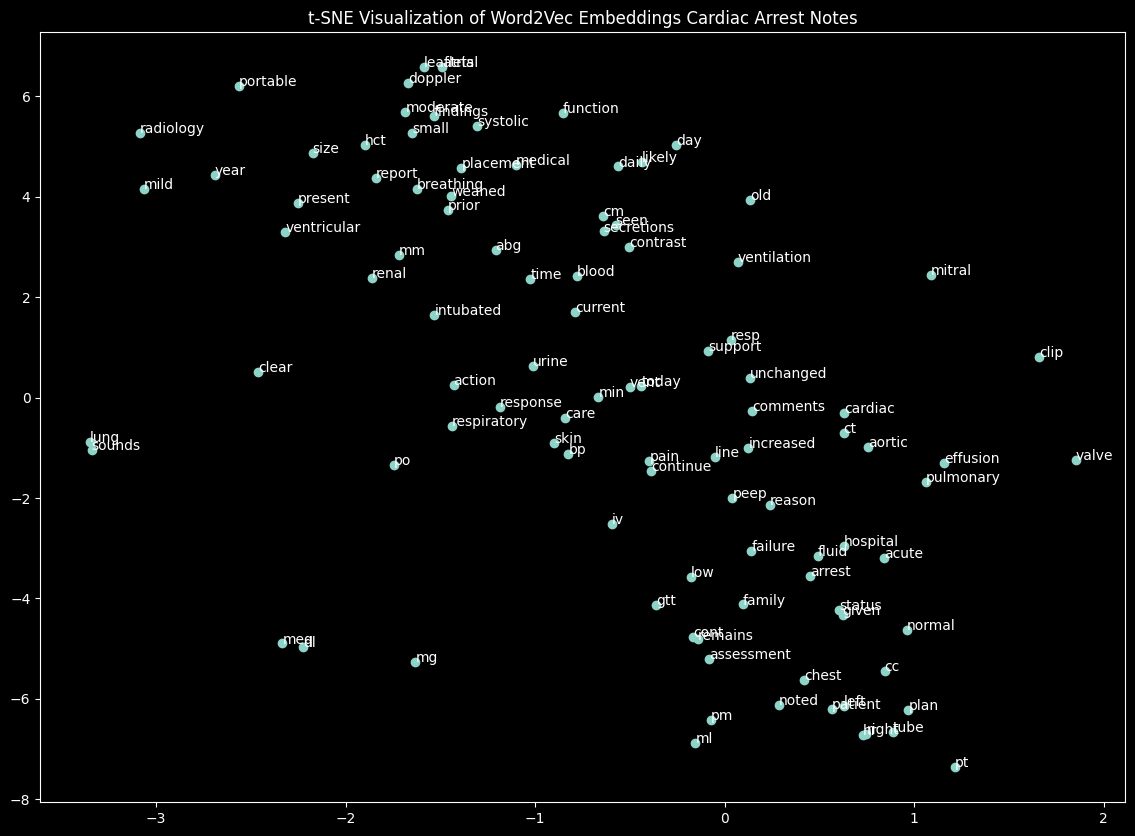

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))
plt.scatter(X_tsne_ca[:, 0], X_tsne_ca[:, 1])

for i, word in enumerate(top_words_ca):
    plt.annotate(word, xy=(X_tsne_ca[i, 0], X_tsne_ca[i, 1]))
    
plt.title('t-SNE Visualization of Word2Vec Embeddings Cardiac Arrest Notes')
plt.show()


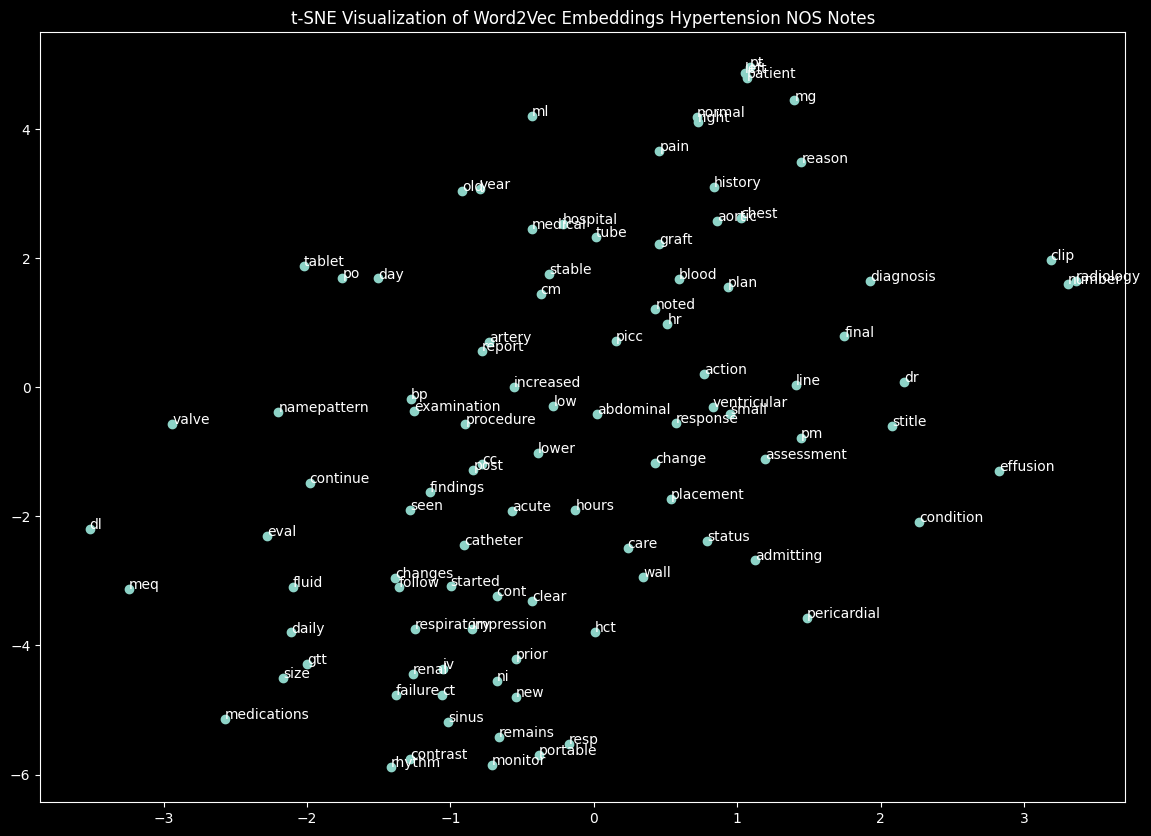

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))
plt.scatter(X_tsne_hy[:, 0], X_tsne_hy[:, 1])

for i, word in enumerate(top_words_hy):
    plt.annotate(word, xy=(X_tsne_hy[i, 0], X_tsne_hy[i, 1]))
    
plt.title('t-SNE Visualization of Word2Vec Embeddings Hypertension NOS Notes')
plt.show()